# Plotando e exportando data views

## Importando bibliotecas

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt

## Definindo data de hoje

In [2]:
data_atual = date.today()
data_em_texto = data_atual.strftime('%d-%m-%Y')

## Definindo funções

In [3]:
# plotar gráfico em linha padronizado
def plot_line(dadosx, dadosy, dados, title, xlabel, ylabel):
  sns.set_palette('Accent')
  sns.set_style('darkgrid')
  ax = sns.lineplot(x=dadosx, y=dadosy, data=dados)
  ax.figure.set_size_inches(12, 6)
  ax.set_title(title, loc='left', fontsize=18)
  ax.set_xlabel(xlabel, fontsize=14)
  ax.set_ylabel(ylabel, fontsize=14)
  ax=ax

## Finalizando o tratamento dos dados

In [4]:
# importando dados
dados_carros = pd.read_csv('dados_carros04-05-2022.csv', sep = ';')
# removendo duplicatas
dados_carros.drop_duplicates(inplace=True)
# definindo o index
dados_carros.set_index('link', inplace=True)

# str(valores) para int(valores)
valores = []
for valor in dados_carros['valor']:
    try:
        valor = int(valor)
        valores.append(valor)
    except Exception:
        valor = valor.split("['")[1].split("']")[0]
        valor = int(valor)
        valores.append(valor)
dados_carros['valor'] = valores

# removendo inconsistências
dados_carros.drop(dados_carros[dados_carros['ano_fabricacao'] == 'Campinas'].index, inplace=True)

# str(anos) para int(anos)
anosf = []
for ano in dados_carros['ano_fabricacao']:
    try:
        ano = int(ano)
        anosf.append(ano)
    except Exception:
        print('ano')
dados_carros['ano_fabricacao'] = anosf
anosm = []
for ano in dados_carros['ano_modelo']:
    try:
        ano = int(ano)
        anosm.append(ano)
    except Exception:
        print('ano')
dados_carros['ano_modelo'] = anosm

# removendo colunas duplicadas
dados_carros.drop(['ano'], axis = 1, inplace = True)

In [5]:
# eliminando dados improváveis
dados_carros = dados_carros[dados_carros['valor']<=dados_carros['valor'].quantile(0.9997)]
dados_carros = dados_carros[dados_carros['kms']<=dados_carros['kms'].quantile(0.997)]
dados_carros = dados_carros.drop(dados_carros[(dados_carros['kms'] != 0) & (dados_carros['kms'] <= 1000)].index)

In [6]:
# tratando kms
kms_lista = []
for kms in dados_carros['kms']:
  kms = int(kms)
  kms_lista.append(kms)
dados_carros['kms'] = kms_lista

## Definindo variáveis

In [7]:
milhagem = []
for kms in dados_carros['kms']:
  milhagem.append(int(kms/10000)*10)
dados_carros['milhagem'] = milhagem

In [8]:
carros_usados = dados_carros[dados_carros['kms']>=10000]

In [9]:
carros_baratos = dados_carros[dados_carros['valor'] <= 50000]

In [10]:
carros_baratos_usados = carros_baratos[carros_baratos['kms']>=10000]

In [11]:
# agrupamento para desvalorizacao por milhagem independente do modelo do carro
grupos_milhagem = dados_carros.groupby(by = ['milhagem', 'carro'])
grupos_milhagem_mean_valor = grupos_milhagem.mean()[['valor']]
grupos_milhagem_mean_valor = grupos_milhagem_mean_valor.reset_index()
grupos_milhagem_mean_valor['desvalorizacao'] = grupos_milhagem_mean_valor['valor'].diff()
grupos_milhagem_mean_valor['percentil_desvalorizado'] = grupos_milhagem_mean_valor['desvalorizacao']/(grupos_milhagem_mean_valor['valor']-grupos_milhagem_mean_valor['desvalorizacao'])

In [12]:
# agrupamento para desvalorizacao por milhagem dependente do modelo do carro
grupos_milhagem_por_carro_mean_valor = dados_carros.groupby(by = ['milhagem', 'carro', 'ano_modelo', 'marca'])
grupos_milhagem_por_carro_mean_valor = grupos_milhagem_por_carro_mean_valor.mean()[['valor']]
grupos_milhagem_por_carro_mean_valor = grupos_milhagem_por_carro_mean_valor.reset_index()
lista_desvalorizacao = []
for i in range(len(grupos_milhagem_por_carro_mean_valor)):
    if grupos_milhagem_por_carro_mean_valor.iloc[i]['milhagem'] - grupos_milhagem_por_carro_mean_valor.iloc[i-1]['milhagem'] == 0:
        valor_anterior = grupos_milhagem_por_carro_mean_valor[(grupos_milhagem_por_carro_mean_valor['carro'] == grupos_milhagem_por_carro_mean_valor.iloc[i]['carro']) & (grupos_milhagem_por_carro_mean_valor['milhagem'] < grupos_milhagem_por_carro_mean_valor.iloc[i]['milhagem'])]['valor'].max()
        try:
            valor_anterior = valor_anterior.mean()
        except Exception:
            pass
        desvalorizacao = (valor_anterior - grupos_milhagem_por_carro_mean_valor.iloc[i]['valor'])/(grupos_milhagem_por_carro_mean_valor.iloc[i]['milhagem'] - grupos_milhagem_por_carro_mean_valor[grupos_milhagem_por_carro_mean_valor['milhagem'] < grupos_milhagem_por_carro_mean_valor.iloc[i]['milhagem']]['milhagem'].max())
    else:
        desvalorizacao = None
    lista_desvalorizacao.append(desvalorizacao)
grupos_milhagem_por_carro_mean_valor['desvalorizacao_por_milhagem'] = lista_desvalorizacao
grupos_milhagem_por_carro_mean_valor = grupos_milhagem_por_carro_mean_valor[grupos_milhagem_por_carro_mean_valor['milhagem'] > 150]
grupos_milhagem_por_carro_mean_valor['percentil_desvalorizado'] = grupos_milhagem_por_carro_mean_valor['desvalorizacao_por_milhagem']/(grupos_milhagem_por_carro_mean_valor['valor']-grupos_milhagem_por_carro_mean_valor['desvalorizacao_por_milhagem'])
grupos_milhagem_por_carro_mean_valor.dropna(inplace=True)

## Analisando dados_carros

In [13]:
# preparando variável para o cálculo das médias móveis dos valores por ano de fabricação
dados_carros_temp = dados_carros
valores_normalizados = []
for ano in dados_carros_temp['ano_fabricacao']:
    ano_1anterior = dados_carros[dados_carros_temp['ano_fabricacao']<ano]['ano_fabricacao'].max()
    ano_2anterior = dados_carros[dados_carros_temp['ano_fabricacao']<ano_1anterior]['ano_fabricacao'].max()
    ano_1posterior = dados_carros[dados_carros_temp['ano_fabricacao']>ano]['ano_fabricacao'].min()
    ano_2posterior = dados_carros[dados_carros_temp['ano_fabricacao']>ano_1posterior]['ano_fabricacao'].min()
    n_antes = ano - ano_2anterior
    n_depois = ano_2posterior - ano
    try:
        n_total = int(n_antes + n_depois + 1)
    except Exception:
        pass
    lista_n = []
    for n in range(n_total):
        if n == 0:
            valor_n = dados_carros_temp[dados_carros_temp['ano_fabricacao'] == ano_2anterior]['valor'].mean()
        elif n == n_total-1:
            valor_n = dados_carros_temp[dados_carros_temp['ano_fabricacao'] == ano_2posterior]['valor'].mean()
        elif n == n_antes:
            valor_n = dados_carros_temp[dados_carros_temp['ano_fabricacao'] == ano]['valor'].mean()
        elif n > 0 and n < n_antes:
            valor_n = dados_carros_temp[dados_carros_temp['ano_fabricacao'] == ano_1anterior]['valor'].mean()
        else:
            valor_n = dados_carros_temp[dados_carros_temp['ano_fabricacao'] == ano_1posterior]['valor'].mean()
        lista_n.append(valor_n)
    valor_normalizado = sum(lista_n)/n_total
    valores_normalizados.append(valor_normalizado)
dados_carros_temp['valor_normalizado'] = valores_normalizados

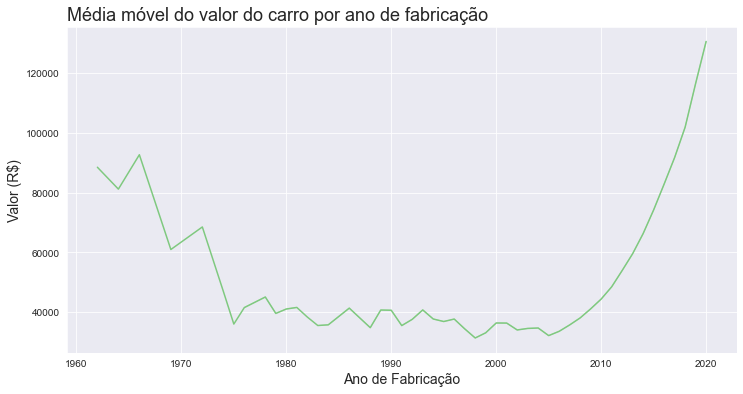

In [14]:
# salvando o valor do carro por ano de fabricação sem filtros de normalização
plot_line('ano_fabricacao', 'valor_normalizado', dados_carros_temp, 'Média móvel do valor do carro por ano de fabricação', 'Ano de Fabricação', 'Valor (R$)')
plt.savefig('gráficos/valor do carro por ano de fabricação/valor fabricacao normalizado' + data_em_texto + '.png')

## Agrupando por milhagem e modelo

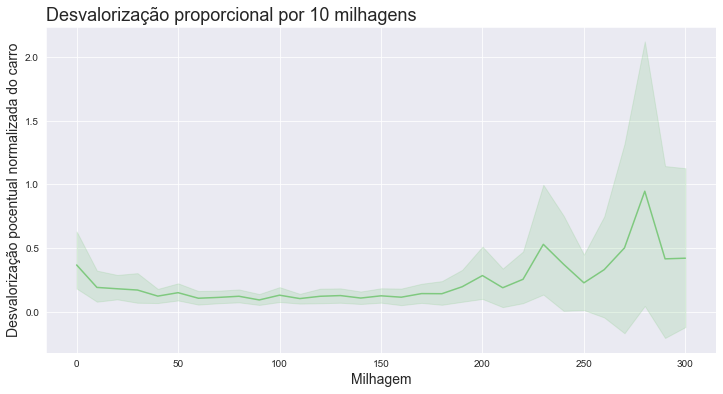

In [15]:
# plotando curva de desvalorização de carros por milhagem
# milhagens acima de 300 foram cortadas porque não haviam dados sufientes
grupos_milhagem_mean_valor = grupos_milhagem_mean_valor[grupos_milhagem_mean_valor['milhagem']<=300]
plot_line('milhagem', 'percentil_desvalorizado', grupos_milhagem_mean_valor, 'Desvalorização proporcional por 10 milhagens', 'Milhagem', 'Desvalorização pocentual normalizada do carro')
plt.savefig('gráficos/percentil desvalorizado por 10 milhagens/percentil 10 milhagens' + data_em_texto + '.png')

In [16]:
# esta tabela representa a proporção desvalorizada em média do carro a cada 1000 km depois de ultrapassados 150 mil km
desvalorizacao_por_marca = grupos_milhagem_por_carro_mean_valor.groupby(by='marca').mean()[['percentil_desvalorizado']].sort_values(by='percentil_desvalorizado')
desvalorizacao_por_marca.to_csv('tabelas/desvalorização por marca/desvalorizacao marca'+data_em_texto+'.csv', index=False, sep=';')
desvalorizacao_por_marca

,percentil_desvalorizado
marca,
MINI,0.002441
Alfa Romeo,0.009848
BMW,0.011155
PEUGEOT,0.017236
CITROEN,0.024453
Hyundai,0.032445
CHEVROLET,0.036853
Mitsubishi,0.037261
Fiat,0.038289
